
# Introduction
In this document, we attempt to establish a direct correlation between the risk of COVID-19 infection, risk mortality, and smoking by exploring the Nexoid COVID-19 medical dataset. 

Additionally, we attempt identify other insights and relationships between features that provide a more nuanced overview of the subject matter, including the impact of pre-existing health conditions and lifestyle factors that contribute to the risk of infection and risk mortality.

In [308]:
# Import Required Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
from pandas.api.types import CategoricalDtype
from scipy.stats import chi2_contingency

warnings.filterwarnings("ignore")

In [309]:
# Load the dataset

df = pd.read_excel("Assignment 1 - Nexoid medical dataset .xlsx")

print("--- Initial Data Types ---")
print(df.dtypes)

--- Initial Data Types ---
survey_date                object
region                     object
country                    object
ip_latitude               float64
ip_longitude              float64
gender                     object
age                        object
height                      int64
weight                      int64
bmi                       float64
blood_type                 object
insurance                  object
income                     object
smoking                    object
alcohol                   float64
cocaine                   float64
contacts_count            float64
public_transport_count    float64
working                    object
worried                   float64
covid19_positive            int64
covid19_symptoms            int64
covid19_contact             int64
asthma                      int64
kidney_disease              int64
liver_disease               int64
compromised_immune          int64
heart_disease               int64
lung_disease         

# Task 1 - Data Type Corrections for Medical Dataset

### Insurance correction

In [310]:
# Check data type of 'insurance' column
print("Data type of 'insurance' column:", df['insurance'].dtype)

# Check for missing values
print("Number of missing values in 'insurance' column:", df['insurance'].isnull().sum())

# Display the first few rows of the 'insurance' column
print("First few rows of 'insurance' column:")
print(df['insurance'].head())

# Display the last few rows of 'insurance' column
print("Last few rows of 'insurance' column:")
print(df['insurance'].tail())

Data type of 'insurance' column: object
Number of missing values in 'insurance' column: 1292
First few rows of 'insurance' column:
0    yes
1    yes
2    yes
3    yes
4    yes
Name: insurance, dtype: object
Last few rows of 'insurance' column:
5784    NaN
5785    NaN
5786    NaN
5787    NaN
5788    NaN
Name: insurance, dtype: object


In [311]:
df['insurance'].value_counts()

insurance
yes      3544
no        622
blank     331
Name: count, dtype: int64

### Date Conversion

In [312]:
def convert_date(date_str):
    if pd.isna(date_str):
        return pd.NaT
    try:
        for fmt in ['%Y-%m-%d %H:%M:%S', '%d/%m/%Y', '%Y-%m-%d']:
            try:
                return pd.to_datetime(date_str, format=fmt)
            except:
                continue
        return pd.to_datetime(date_str, infer_datetime_format=True)
    except:
        return pd.NaT

df['survey_date'] = df['survey_date'].apply(convert_date)


# ##

### Region and Country - Convert to Categorical with 'Unknown'

In [313]:
for col in ['region', 'country']:
    df[col] = df[col].astype('category')
    if 'Unknown' not in df[col].cat.categories:
        df[col] = df[col].cat.add_categories('Unknown')
    df[col] = df[col].fillna('Unknown')
    
    print(f"\n{col.capitalize()} Categories:")
    print(df[col].value_counts())


Region Categories:
region
Unknown    4227
EU          801
SA          399
AS          206
AF           79
OC           77
Name: count, dtype: int64

Country Categories:
country
US    3885
GB     365
BR     270
CA     208
MX      94
      ... 
BS       1
BM       1
AZ       1
AW       1
JE       1
Name: count, Length: 95, dtype: int64


### Drop longitude and latitude due to no meaningful significance

In [314]:
df.drop(columns=['ip_longitude', 'ip_latitude'], inplace=True)

### Age - Convert to Ordered Categorical

In [315]:
df['age'] = df['age'].replace("100_110", "90_plus")
age_order = ['0_10', '10_20', '20_30', '30_40', '40_50', '50_60', 
             '60_70', '70_80', '80_90', '90_plus']
age_dtype = pd.api.types.CategoricalDtype(categories=age_order, ordered=True)
df['age'] = df['age'].astype(age_dtype)

# Display age categories and their counts
print("Age Categories:")
print(df['age'].cat.categories)
print("\nAge Value Counts:")
df['age'].value_counts(sort=False)

Age Categories:
Index(['0_10', '10_20', '20_30', '30_40', '40_50', '50_60', '60_70', '70_80',
       '80_90', '90_plus'],
      dtype='object')

Age Value Counts:


age
0_10         14
10_20       205
20_30       996
30_40      1412
40_50      1111
50_60       926
60_70       765
70_80       354
80_90         0
90_plus       6
Name: count, dtype: int64

### Gender

In [316]:
df['gender'] = df['gender'].astype('category')
print("Gender Categories:")
df['gender'].value_counts()

Gender Categories:


gender
male      2985
female    2790
other       14
Name: count, dtype: int64

### Height and Weight - Convert to Integer

In [317]:
df['height'] = df['height'].astype('Int64')  # Using Int64 to handle NaN values
df['weight'] = df['weight'].astype('Int64')

print("Height Summary:")
print(df['height'].describe())
print("\nWeight Summary:")
print(df['weight'].describe())


# ### 6. BMI - Keep as Float

Height Summary:
count        5789.0
mean     172.030057
std         10.9176
min           110.0
25%           164.0
50%           172.0
75%           180.0
max           238.0
Name: height, dtype: Float64

Weight Summary:
count       5789.0
mean     84.773881
std        23.5763
min           44.0
25%           68.0
50%           82.0
75%           96.0
max          180.0
Name: weight, dtype: Float64


 ### Blood Type - Convert to Categorical with 'Unknown'

In [318]:
df['bmi'] = df['bmi'].astype('float64')
print("BMI Summary:")
df['bmi'].describe()

BMI Summary:


count    5789.000000
mean       28.570116
std         7.674528
min        11.900000
25%        23.500000
50%        26.800000
75%        31.800000
max       125.000000
Name: bmi, dtype: float64

In [319]:
df['blood_type'] = df['blood_type'].astype('category')
if 'Unknown' not in df['blood_type'].cat.categories:
    df['blood_type'] = df['blood_type'].cat.add_categories('Unknown')
df['blood_type'] = df['blood_type'].fillna('Unknown')

print("Blood Type Categories:")
df['blood_type'].value_counts()

Blood Type Categories:


blood_type
unknown    1784
ap         1279
op         1251
on          417
bp          394
an          244
abp         191
Unknown     100
bn           91
abn          38
Name: count, dtype: int64

### Insurance to categorical

In [320]:
# Convert to Boolean with NA for Blank and Unknown
df['insurance'] = df['insurance'].str.title()
df['insurance'] = df['insurance'].map({'Yes': True, 'No': False, 'Blank': pd.NA, 'Unknown': pd.NA})
print("Insurance Value Counts:")
df['insurance'].value_counts()

Insurance Value Counts:


insurance
True     3544
False     622
Name: count, dtype: int64

### Income - Convert to Categorical

In [321]:
df['income'] = df['income'].astype('category')
print("Income Categories:")
df['income'].value_counts()


# ### 10. Smoking - Convert to Categorical with Bins

Income Categories:


income
med      2142
high     1886
low       398
blank     122
gov        88
Name: count, dtype: int64

### Smoking to bins

In [322]:
smoking_bins = {
    'quit0': 'Former Smoker',
    'quit5': 'Former Smoker',
    'quit10': 'Former Smoker',
    'vape': 'Vape User',
    'yesheavy': 'Heavy Smoker',
    'light': 'Light Smoker',
    'medium': 'Medium Smoker',
    'never': 'Never Smoked',
    -1: 'Unknown'
}
df['smoking'] = df['smoking'].replace(smoking_bins)
df['smoking'] = df['smoking'].astype('category')

print("Smoking Categories:")
df['smoking'].value_counts()

Smoking Categories:


smoking
Never Smoked     3713
Former Smoker    1277
Vape User         247
yesmedium         230
yeslight          206
Heavy Smoker       80
Name: count, dtype: int64

### Alcohol - Convert to Categorical Ordinal

In [323]:
df['alcohol'] = df['alcohol'].replace(-1, 'Unknown')
df['alcohol'] = df['alcohol'].astype('category')

print("Alcohol Categories:")
df['alcohol'].value_counts()


# ### 12. Cocaine - Convert to Categorical with Unknown

Alcohol Categories:


alcohol
Unknown    1920
0.0        1275
1.0         612
2.0         466
3.0         310
4.0         247
5.0         194
7.0         166
14.0        117
10.0        108
6.0          86
13.0         72
12.0         64
8.0          48
9.0          39
11.0         27
Name: count, dtype: int64

In [324]:
df['cocaine'] = df['cocaine'].replace(-1, 'Unknown')
df['cocaine'] = df['cocaine'].astype('category')

print("Cocaine Categories:")
df['cocaine'].value_counts()

Cocaine Categories:


cocaine
Unknown    1078
0.0         228
1.0          33
2.0          17
5.0          14
4.0          12
3.0          12
7.0           7
9.0           5
28.0          4
10.0          3
20.0          3
27.0          3
6.0           2
16.0          2
23.0          2
25.0          1
15.0          1
22.0          1
21.0          1
14.0          1
Name: count, dtype: int64

### Contact Counts - Convert to Int64

In [325]:
df['contacts_count'] = df['contacts_count'].astype('Int64')
df['public_transport_count'] = df['public_transport_count'].astype('Int64')

print("Contacts Count Summary:")
print(df['contacts_count'].describe())
print("\nPublic Transport Count Summary:")
print(df['public_transport_count'].describe())

Contacts Count Summary:
count      5747.0
mean     7.828432
std      6.672943
min           0.0
25%           3.0
50%           5.0
75%          10.0
max          21.0
Name: contacts_count, dtype: Float64

Public Transport Count Summary:
count      4572.0
mean     0.415573
std      1.811049
min           0.0
25%           0.0
50%           0.0
75%           0.0
max          15.0
Name: public_transport_count, dtype: Float64


### Working - Convert to Categorical

In [326]:
df['working'] = df['working'].astype('category')
print("Working Status Categories:")
df['working'].value_counts()

Working Status Categories:


working
stopped                1732
never                  1577
travel critical        1312
travel non critical     620
home                    506
Name: count, dtype: int64

### Worried - Convert to Integer

In [327]:
df['worried'] = df['worried'].astype('Int64')
print("Worried Level Summary:")
df['worried'].describe()

Worried Level Summary:


count      4518.0
mean     3.530987
std      0.792812
min           1.0
25%           3.0
50%           4.0
75%           4.0
max           5.0
Name: worried, dtype: Float64

### Health Conditions - Convert to Boolean

In [328]:
health_conditions = [
    'covid19_positive', 'covid19_symptoms', 'covid19_contact',
    'asthma', 'kidney_disease', 'liver_disease', 'compromised_immune',
    'heart_disease', 'lung_disease', 'diabetes', 'hiv_positive',
    'other_chronic', 'nursing_home', 'health_worker'
]

for col in health_conditions:
    df[col] = df[col].astype('bool')
    
print("Health Conditions Summary:")
for col in health_conditions:
    print(f"\n{col}:")
    print(df[col].value_counts())

Health Conditions Summary:

covid19_positive:
covid19_positive
False    3454
True     2335
Name: count, dtype: int64

covid19_symptoms:
covid19_symptoms
False    4792
True      997
Name: count, dtype: int64

covid19_contact:
covid19_contact
False    4800
True      989
Name: count, dtype: int64

asthma:
asthma
False    5032
True      757
Name: count, dtype: int64

kidney_disease:
kidney_disease
False    5726
True       63
Name: count, dtype: int64

liver_disease:
liver_disease
False    5745
True       44
Name: count, dtype: int64

compromised_immune:
compromised_immune
False    5444
True      345
Name: count, dtype: int64

heart_disease:
heart_disease
False    5607
True      182
Name: count, dtype: int64

lung_disease:
lung_disease
False    5654
True      135
Name: count, dtype: int64

diabetes:
diabetes
False    5320
True      469
Name: count, dtype: int64

hiv_positive:
hiv_positive
False    5766
True       23
Name: count, dtype: int64

other_chronic:
other_chronic
False    5411
True 

### Risk Values - Convert to Float and Normalize

In [329]:
df['risk_infection'] = df['risk_infection'].astype('float64') / 100
df['risk_mortality'] = df['risk_mortality'].astype('float64') / 100

print("Risk Infection Summary:")
print(df['risk_infection'].describe())
print("\nRisk Mortality Summary:")
print(df['risk_mortality'].describe())

Risk Infection Summary:
count    5789.000000
mean        0.509772
std         0.440276
min         0.050000
25%         0.050000
50%         0.370000
75%         1.000000
max         1.000000
Name: risk_infection, dtype: float64

Risk Mortality Summary:
count    5789.000000
mean        0.005623
std         0.010778
min         0.000500
25%         0.000500
50%         0.001560
75%         0.005990
max         0.286980
Name: risk_mortality, dtype: float64


### Final Data Types Check

In [330]:
print("Final Data Types:")
df.dtypes

Final Data Types:


survey_date               datetime64[ns]
region                          category
country                         category
gender                          category
age                             category
height                             Int64
weight                             Int64
bmi                              float64
blood_type                      category
insurance                         object
income                          category
smoking                         category
alcohol                         category
cocaine                         category
contacts_count                     Int64
public_transport_count             Int64
working                         category
worried                            Int64
covid19_positive                    bool
covid19_symptoms                    bool
covid19_contact                     bool
asthma                              bool
kidney_disease                      bool
liver_disease                       bool
compromised_immu


# Task 2 - Data Preparation - Identify issues and clean/transform

### Identify Skewness in Numerical Variables

height: -0.392
weight: 1.140
bmi: 1.977
contacts_count: 0.928
public_transport_count: 5.682
worried: -0.362
risk_infection: 0.088
risk_mortality: 7.258


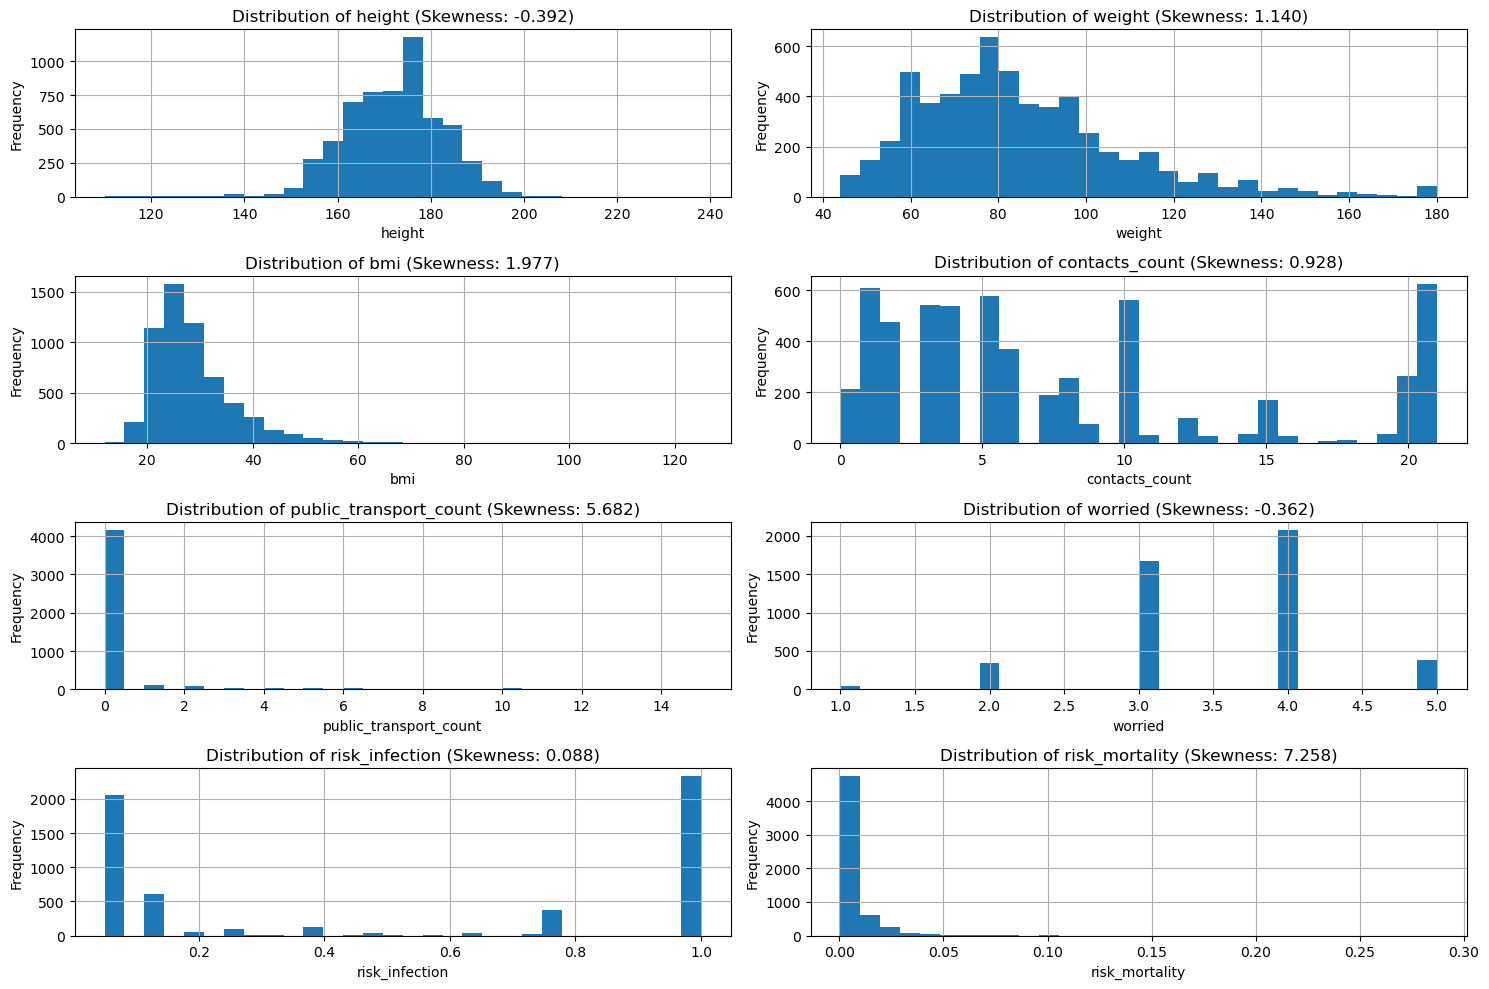

In [331]:
numerical_cols = df.select_dtypes(include=[np.number]).columns
skewness_results = {}

for col in numerical_cols:
    if col in df.columns:
        skewness = df[col].skew()
        skewness_results[col] = skewness
        print(f"{col}: {skewness:.3f}")

# Visualize distributions
plt.figure(figsize=(15, 10))
for i, col in enumerate(['height', 'weight', 'bmi', 'contacts_count', 'public_transport_count', 'worried', 'risk_infection', 'risk_mortality'], 1):
    plt.subplot(4, 2, i)
    df[col].hist(bins=30)
    plt.title(f'Distribution of {col} (Skewness: {df[col].skew():.3f})')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### Identify Missing Values and Errors

In [332]:
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

insurance                 1623
income                    1153
smoking                     36
alcohol                     38
cocaine                   4359
contacts_count              42
public_transport_count    1217
working                     42
worried                   1271
dtype: int64


### Visualise the missing data...

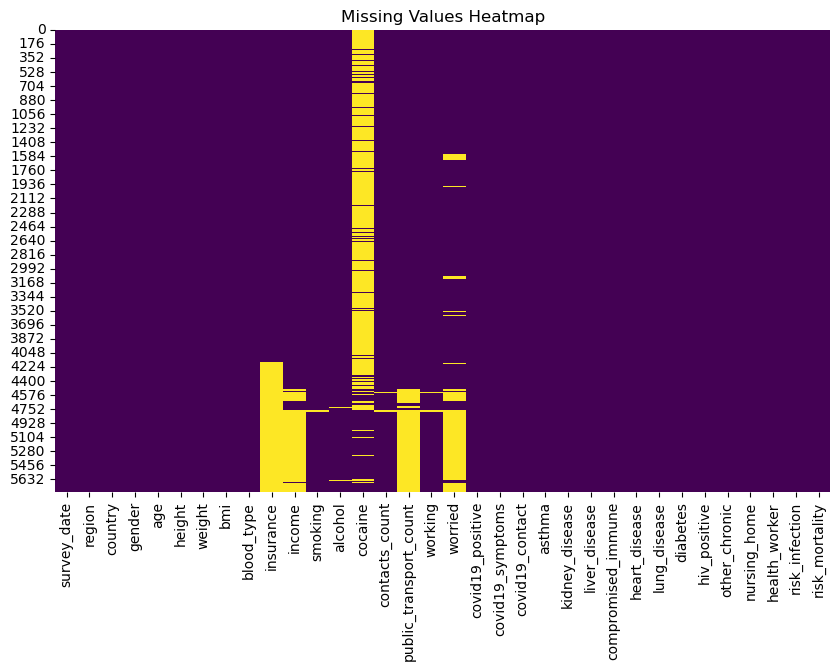

In [333]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

survey_date                  0
region                       0
country                      0
gender                       0
age                          0
height                       0
weight                       0
bmi                          0
blood_type                   0
insurance                 1623
income                    1153
smoking                     36
alcohol                     38
cocaine                   4359
contacts_count              42
public_transport_count    1217
working                     42
worried                   1271
covid19_positive             0
covid19_symptoms             0
covid19_contact              0
asthma                       0
kidney_disease               0
liver_disease                0
compromised_immune           0
heart_disease                0
lung_disease                 0
diabetes                     0
hiv_positive                 0
other_chronic                0
nursing_home                 0
health_worker                0
risk_inf

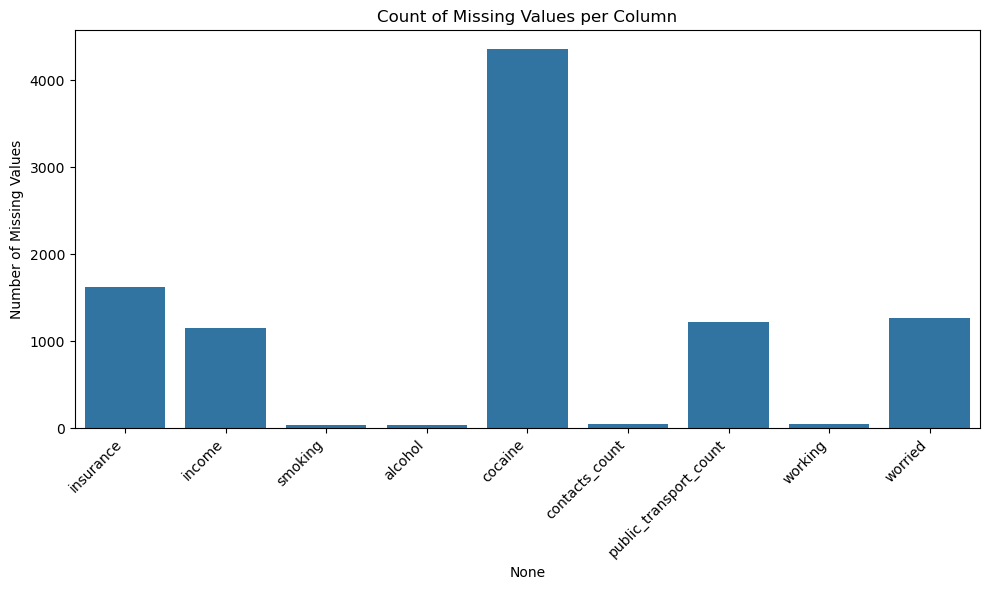

In [334]:
# Again as histogram
print(df.isnull().sum())

# Plotting missing values
missing_counts = df.isnull().sum()
missing_counts = missing_counts[missing_counts > 0] # Only plot columns with missing values
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_counts.index, y=missing_counts.values)
plt.xticks(rotation=45, ha='right')
plt.title('Count of Missing Values per Column')
plt.ylabel('Number of Missing Values')
plt.tight_layout()
plt.show()

### Potential Anomalies in Numerical Data


height - Outliers based on IQR:
Number of outliers: 51
Range of outliers: 110 to 238


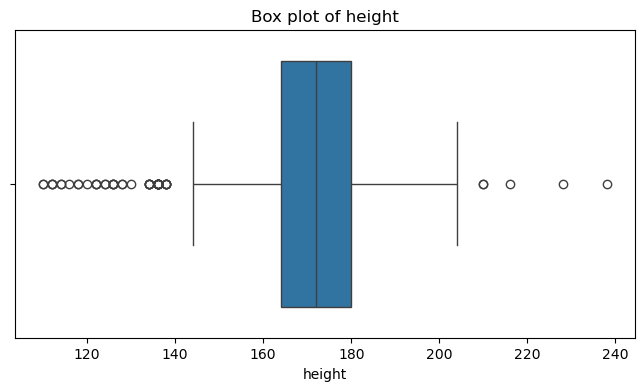


weight - Outliers based on IQR:
Number of outliers: 170
Range of outliers: 140 to 180


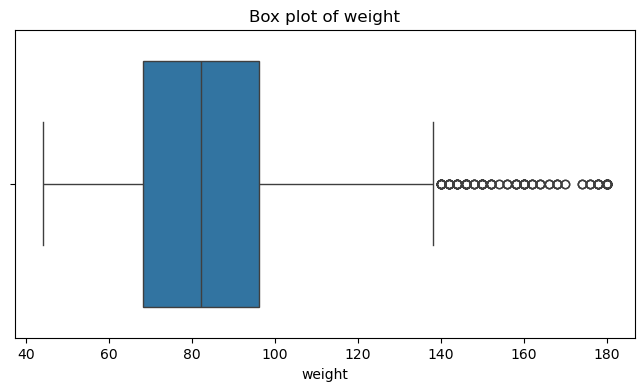


bmi - Outliers based on IQR:
Number of outliers: 258
Range of outliers: 44.3 to 125.0


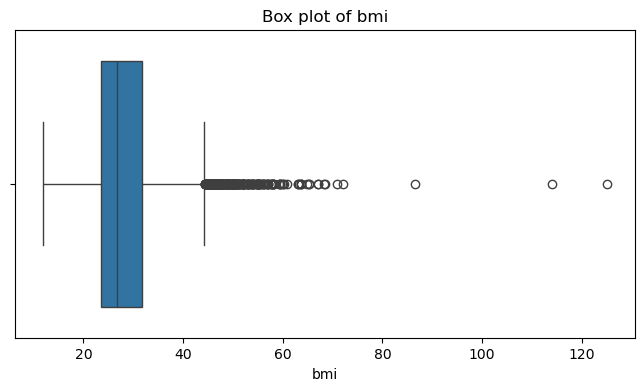

In [335]:
for col in ['height', 'weight', 'bmi']:
    print(f"\n{col} - Outliers based on IQR:")
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    print(f"Number of outliers: {len(outliers)}")
    if len(outliers) > 0:
        print(f"Range of outliers: {outliers.min()} to {outliers.max()}")

     # Add a box plot for visualization
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Box plot of {col}")
    plt.xlabel(col)
    plt.show()

### Fill missing Risk of Infection percentages with mean values within age brackets

In [336]:
# Calcu late the mean 'risk_infection' for each 'age' group
age_group_means = df.groupby('age')['risk_infection'].transform('mean')

# Fill missing 'risk_infection' values with the calculated age group means
df['risk_infection'].fillna(age_group_means, inplace=True)

# fill remaining NaNs with the global mean of 'risk_infection'
global_mean_risk_infection = df['risk_infection'].mean()
df['risk_infection'].fillna(global_mean_risk_infection, inplace=True)

# Verify that there are no more missing risk_infection values
print(f"Missing 'risk_infection' values after processing: {df['risk_infection'].isnull().sum()}")
print(df.groupby('age')['risk_infection'].mean().head())

Missing 'risk_infection' values after processing: 0
age
0_10     0.512857
10_20    0.603220
20_30    0.640482
30_40    0.553392
40_50    0.480198
Name: risk_infection, dtype: float64


### Fill Missing BMI Values with Median

In [337]:
bmi_median = df['bmi'].median()
df['bmi'].fillna(bmi_median, inplace=True)

print(f"Missing BMI values filled with median: {bmi_median}")
print(f"Number of remaining NaNs in BMI: {df['bmi'].isnull().sum()}")

Missing BMI values filled with median: 26.8
Number of remaining NaNs in BMI: 0


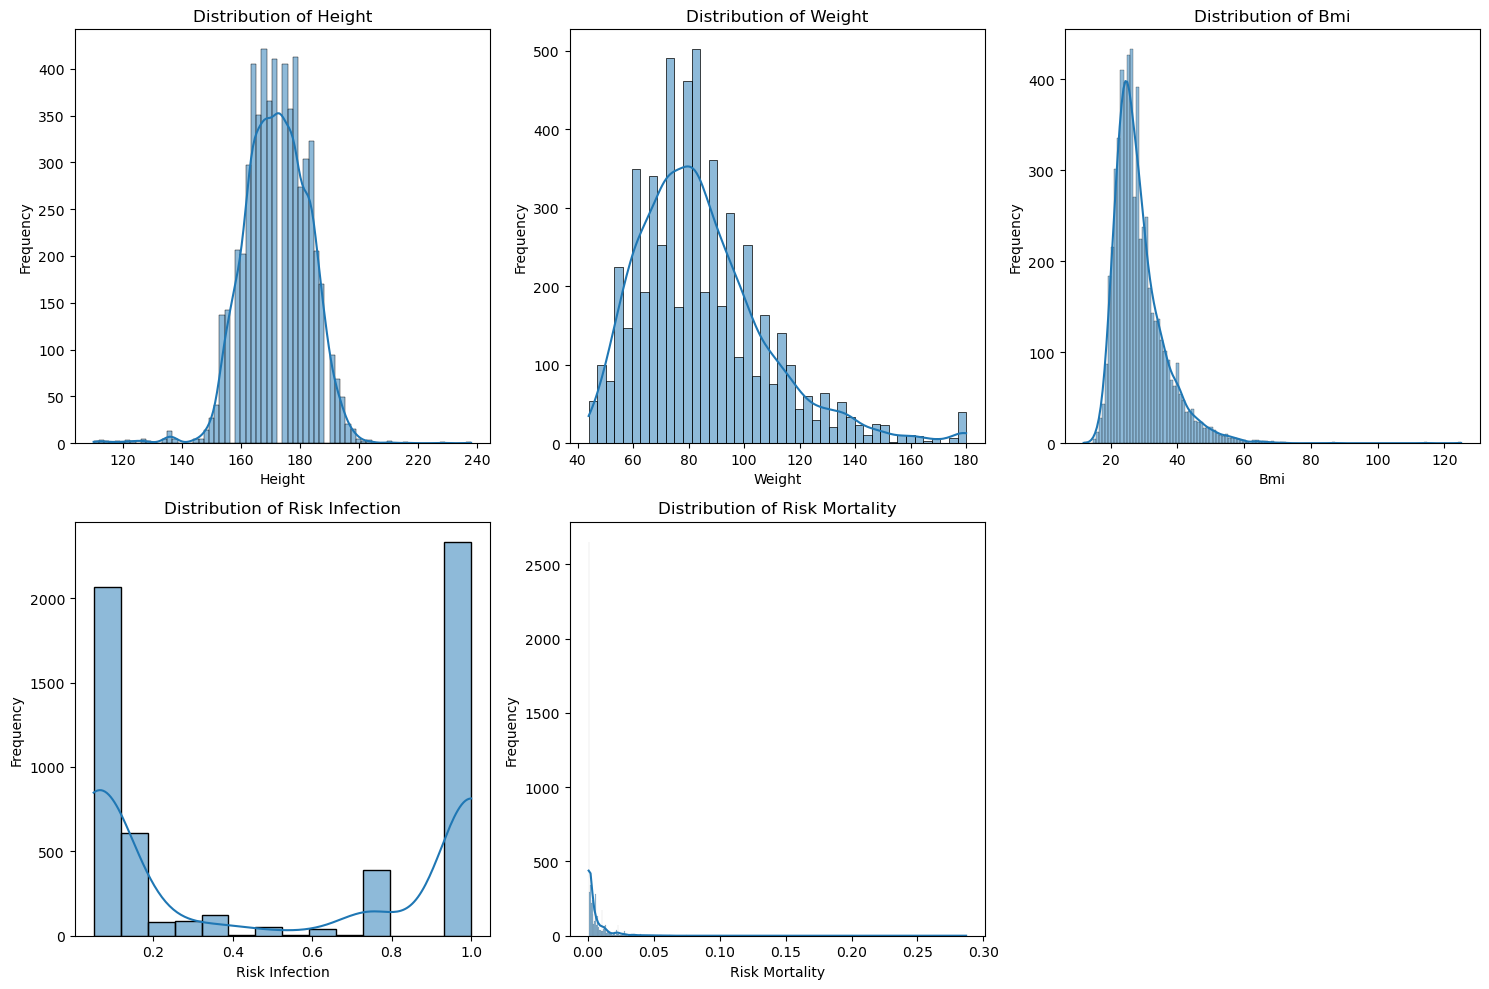

In [338]:
numerical_cols = ['height', 'weight', 'bmi', 'risk_infection', 'risk_mortality']

plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col.replace("_", " ").title()}')
    plt.xlabel(col.replace("_", " ").title())
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Task 3 - Data Mining and Feature Selection

### Calculation infection rates by smoking category

In [339]:
# Create  table for smoking status vs COVID-19 positive
contingency_table = pd.crosstab(df["smoking"], df["covid19_positive"])

print("--- COVID-19 Infection Analysis by Smoking Status ---\n")

# Display frequency distributions
print("--- COVID-19 Positive Distribution ---")
covid_dist = df["covid19_positive"].value_counts(normalize=True) * 100
print(f"Positive: {covid_dist[True]:.1f}%")
print(f"Negative: {covid_dist[False]:.1f}%")

print("\n--- Smoking Status Distribution ---")
smoking_dist = df["smoking"].value_counts(normalize=True) * 100
for category, percentage in smoking_dist.items():
    print(f"{category}: {percentage:.1f}%")

    
# Calculate infection rates by smoking category
infection_rates = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100
infection_summary = pd.DataFrame({
    'Total_Cases': contingency_table.sum(axis=1),
    'COVID_Positive': contingency_table[True],
    'Infection_Rate_%': infection_rates[True].round(2)
}).sort_values('Infection_Rate_%', ascending=False)

print("--- COVID-19 Infection Rates by Smoking Status ---")
print(infection_summary.to_string())

--- COVID-19 Infection Analysis by Smoking Status ---

--- COVID-19 Positive Distribution ---
Positive: 40.3%
Negative: 59.7%

--- Smoking Status Distribution ---
Never Smoked: 64.5%
Former Smoker: 22.2%
Vape User: 4.3%
yesmedium: 4.0%
yeslight: 3.6%
Heavy Smoker: 1.4%
--- COVID-19 Infection Rates by Smoking Status ---
               Total_Cases  COVID_Positive  Infection_Rate_%
smoking                                                     
Heavy Smoker            80              47             58.75
Vape User              247             125             50.61
yesmedium              230             111             48.26
Former Smoker         1277             531             41.58
yeslight               206              85             41.26
Never Smoked          3713            1400             37.71


### Visualise relationship

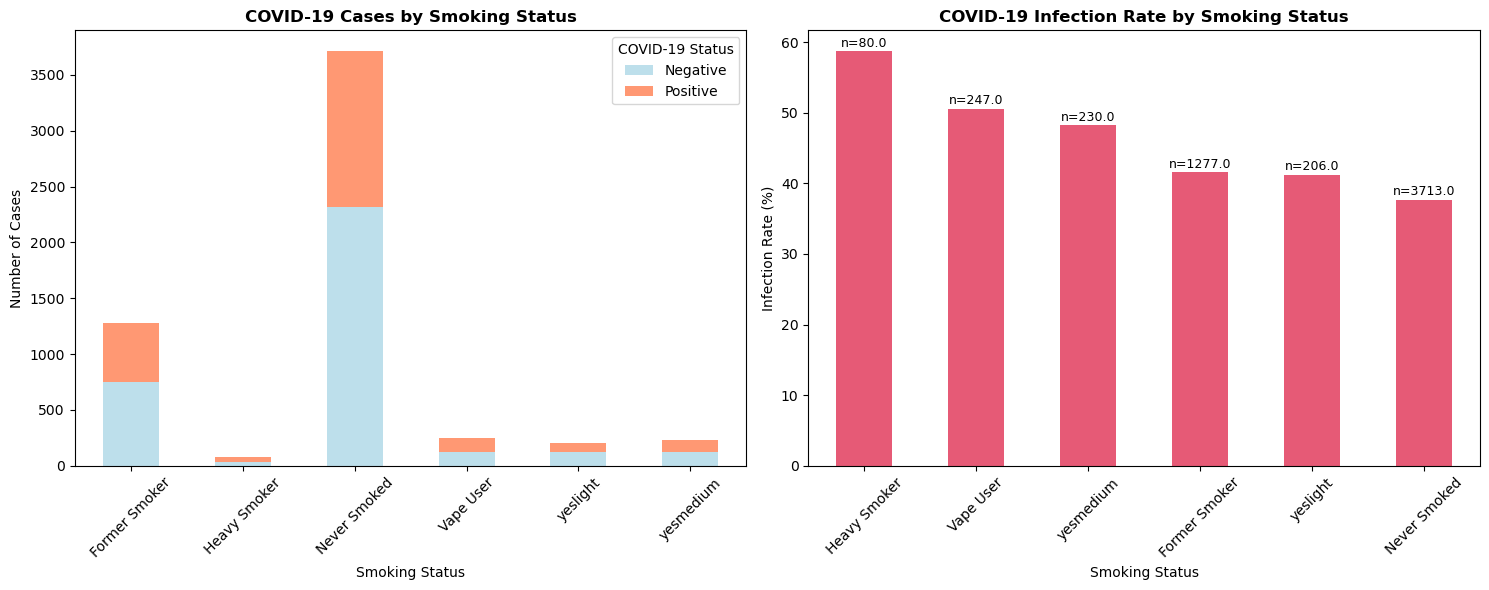

In [340]:

# Visualize the relationship
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Stacked bar chart
contingency_table.plot(kind="bar", stacked=True, ax=ax1, 
                      color=['lightblue', 'coral'], alpha=0.8)
ax1.set_title("COVID-19 Cases by Smoking Status", fontweight='bold', fontsize=12)
ax1.set_ylabel("Number of Cases")
ax1.set_xlabel("Smoking Status")
ax1.legend(['Negative', 'Positive'], title='COVID-19 Status')
ax1.tick_params(axis='x', rotation=45)

# Infection rate bar chart
infection_summary['Infection_Rate_%'].plot(kind='bar', ax=ax2, 
                                         color='crimson', alpha=0.7)
ax2.set_title("COVID-19 Infection Rate by Smoking Status", fontweight='bold', fontsize=12)
ax2.set_ylabel("Infection Rate (%)")
ax2.set_xlabel("Smoking Status")
ax2.tick_params(axis='x', rotation=45)

# Add sample size annotations
for i, (idx, row) in enumerate(infection_summary.iterrows()):
    ax2.annotate(f'n={row["Total_Cases"]}', 
                xy=(i, row['Infection_Rate_%']), 
                xytext=(0, 3), textcoords='offset points',
                ha='center', fontsize=9)

plt.tight_layout()
plt.show()

### Correlation of smoking and covid-19 infections by week

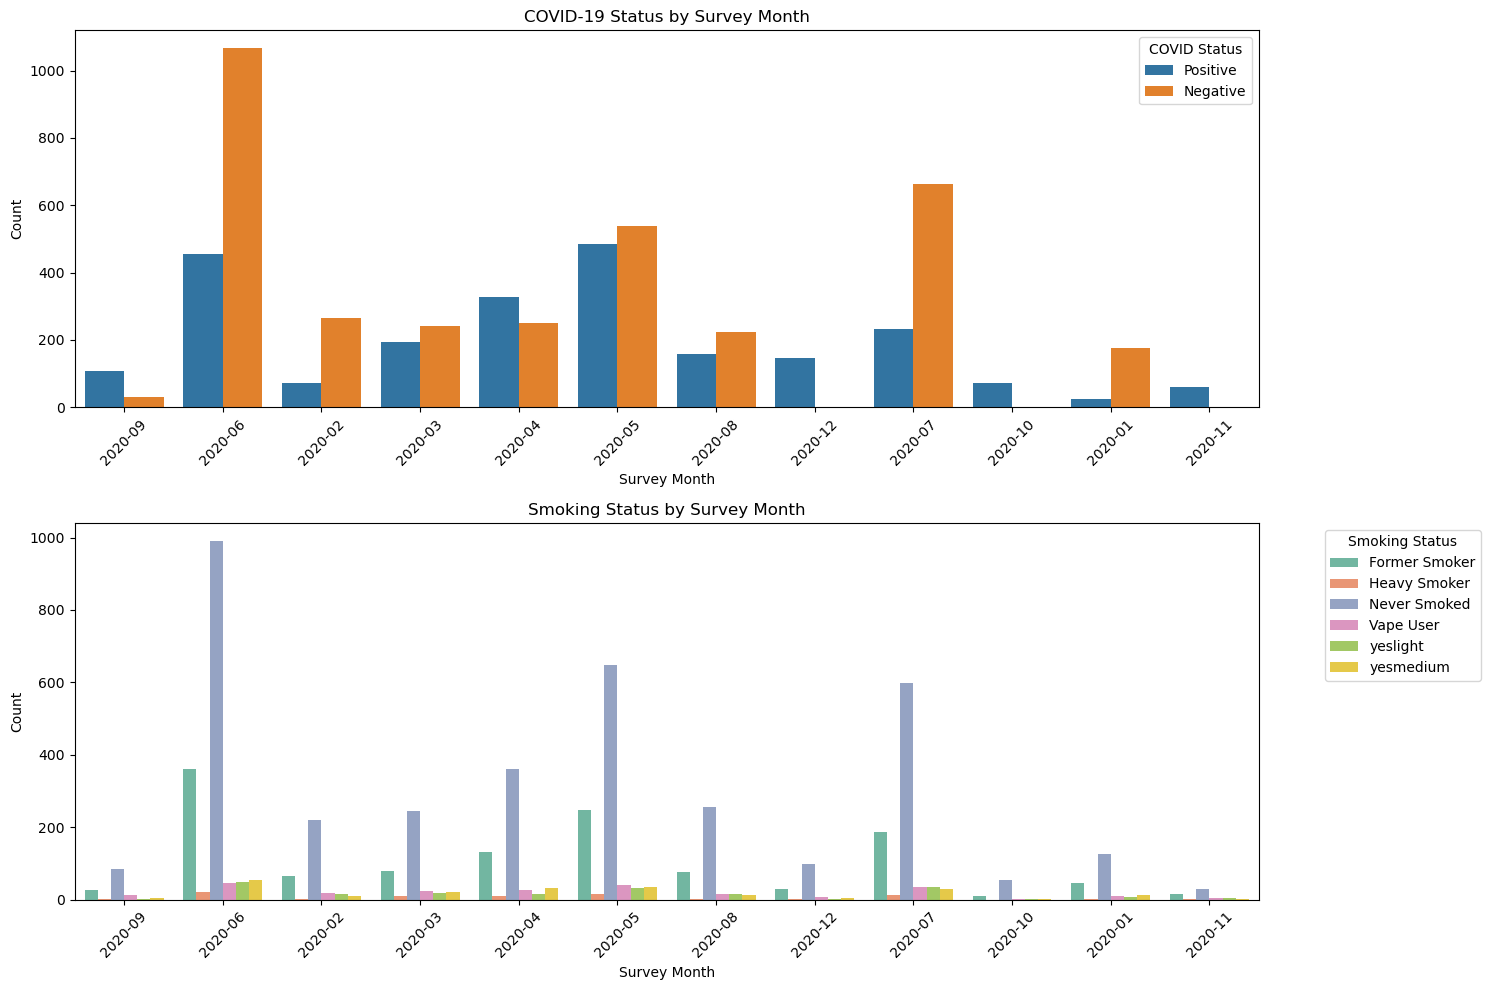

In [341]:
# Convert the survey date to a datetime object
df['survey_date'] = pd.to_datetime(df['survey_date'])

# Create monthly grouping
df['survey_month'] = df['survey_date'].dt.to_period('M')
df['month_label'] = df['survey_month'].dt.strftime('%Y-%m')

# Create a new column for COVID-19 status
df['covid_status'] = df['covid19_positive'].apply(lambda x: 'Positive' if x == 1 else 'Negative')

# Create subplots
plt.figure(figsize=(15, 10))

# Subplot 1: COVID-19 Status by Survey Month
plt.subplot(2, 1, 1)
sns.countplot(data=df, x='month_label', hue='covid_status')
plt.title('COVID-19 Status by Survey Month')
plt.xlabel('Survey Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='COVID Status')

# Subplot 2: Smoking Status by Survey Month
plt.subplot(2, 1, 2)
sns.countplot(data=df, x='month_label', hue='smoking', palette='Set2')
plt.title('Smoking Status by Survey Month')
plt.xlabel('Survey Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Smoking Status', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### Statistical significance testing - COVID-19 and Smoking Relationship

 Based on these findings, smoking status should be retained as a feature in our models, potentially with category consolidation for groups with small sample sizes.

In [342]:
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print("--- Statistical Analysis ---")
print(f"Chi-squared statistic: {chi2_stat:.4f}")
print(f"p-value: {p_value:.6f}")
print(f"Degrees of freedom: {dof}")

if p_value < 0.05:
    print("Statistically significant relationship detected")
else:
    print("No statistically significant relationshi")

--- Statistical Analysis ---
Chi-squared statistic: 39.4614
p-value: 0.000000
Degrees of freedom: 5
Statistically significant relationship detected


### Find other relevant correlations between feature pairs in data set

Correlation matrix includes 13 key variables


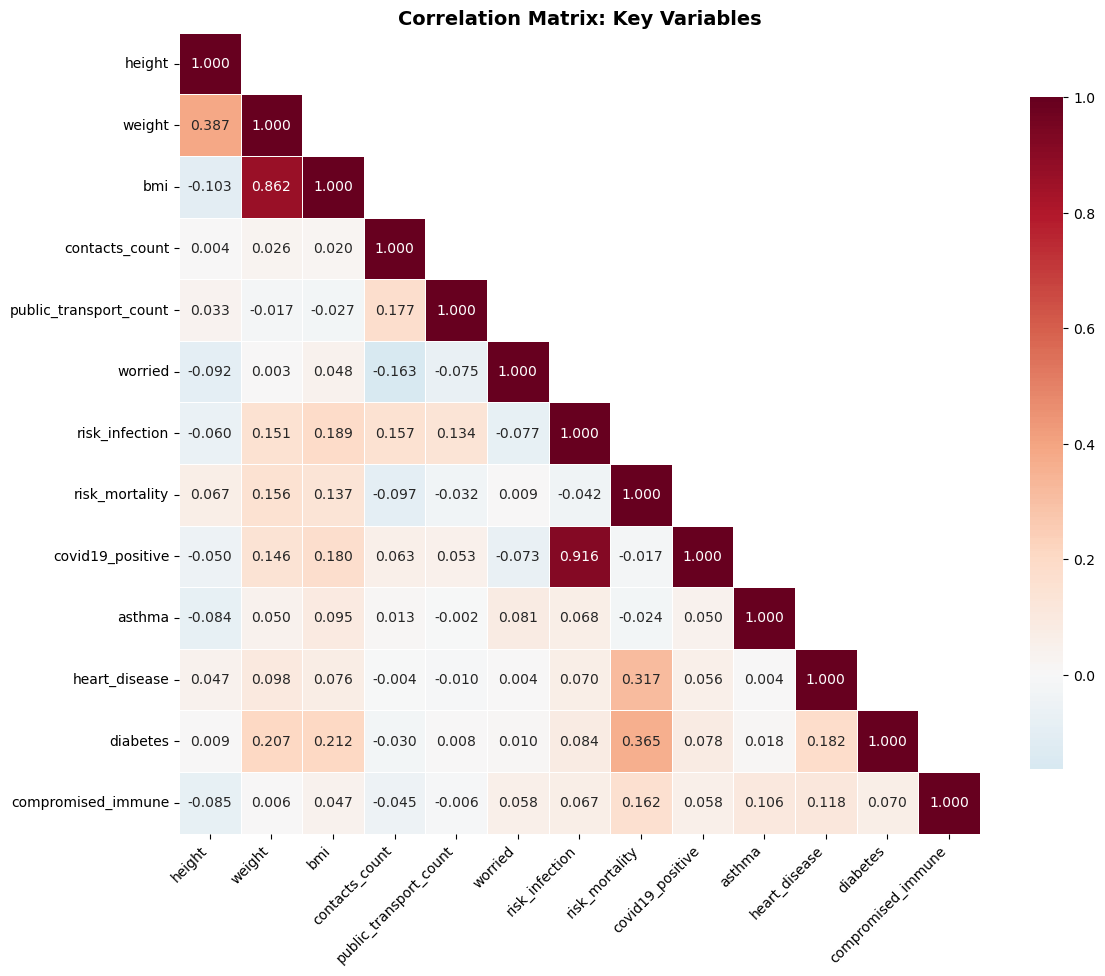

In [343]:

# Visualize correlation matrix
plt.figure(figsize=(12, 10))

# Create correlation heatmap for key variables (including age_numeric if available)
key_vars = ['age_numeric', 'height', 'weight', 'bmi', 'contacts_count', 'public_transport_count', 
           'worried', 'risk_infection', 'risk_mortality', 'covid19_positive',
           'asthma', 'heart_disease', 'diabetes', 'compromised_immune']

# Filter to available variables
available_key_vars = [var for var in key_vars if var in df.columns]
key_corr_matrix = df[available_key_vars].corr()

print(f"Correlation matrix includes {len(available_key_vars)} key variables")

# Create heatmap
mask = np.triu(np.ones_like(key_corr_matrix, dtype=bool), k=1)
sns.heatmap(key_corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
           square=True, linewidths=0.5, fmt='.3f', 
           cbar_kws={"shrink": 0.8})

plt.title('Correlation Matrix: Key Variables', fontweight='bold', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Age-Stratified Analysis: COVID-19 Risk Patterns

To better understand risk factors, we examine how COVID-19 infection rates vary across age groups and smoking categories.

In [344]:
# Create age_numeric if it doesn't already exist
if 'age_numeric' not in df.columns:
    age_mapping = {
        '0_10': 5, '10_20': 15, '20_30': 25, '30_40': 35, '40_50': 45,
        '50_60': 55, '60_70': 65, '70_80': 75, '80_90': 85, '90_plus': 95
    }
    df['age_numeric'] = df['age'].map(age_mapping)
    print("Created age_numeric variable for analysis")
else:
    print("Using existing age_numeric variable")

# Analyze infection rates by age group
age_analysis = df.groupby('age').agg({
    'covid19_positive': ['count', 'sum', 'mean'],
    'risk_mortality': ['mean', 'std']
}).round(4)

age_analysis.columns = ['total_cases', 'covid_positive', 'infection_rate', 
                       'mean_mortality_risk', 'std_mortality_risk']
age_analysis['infection_rate_pct'] = (age_analysis['infection_rate'] * 100).round(2)

print("--- Age-Stratified COVID-19 Analysis ---")
print(age_analysis.to_string())

Created age_numeric variable for analysis
--- Age-Stratified COVID-19 Analysis ---
         total_cases  covid_positive  infection_rate  mean_mortality_risk  std_mortality_risk  infection_rate_pct
age                                                                                                              
0_10              14               6          0.4286               0.0008              0.0005               42.86
10_20            205              86          0.4195               0.0006              0.0002               41.95
20_30            996             506          0.5080               0.0006              0.0004               50.80
30_40           1412             633          0.4483               0.0006              0.0003               44.83
40_50           1111             422          0.3798               0.0033              0.0030               37.98
50_60            926             369          0.3985               0.0057              0.0044               39.85
60_70

### Visualize age-related patterns

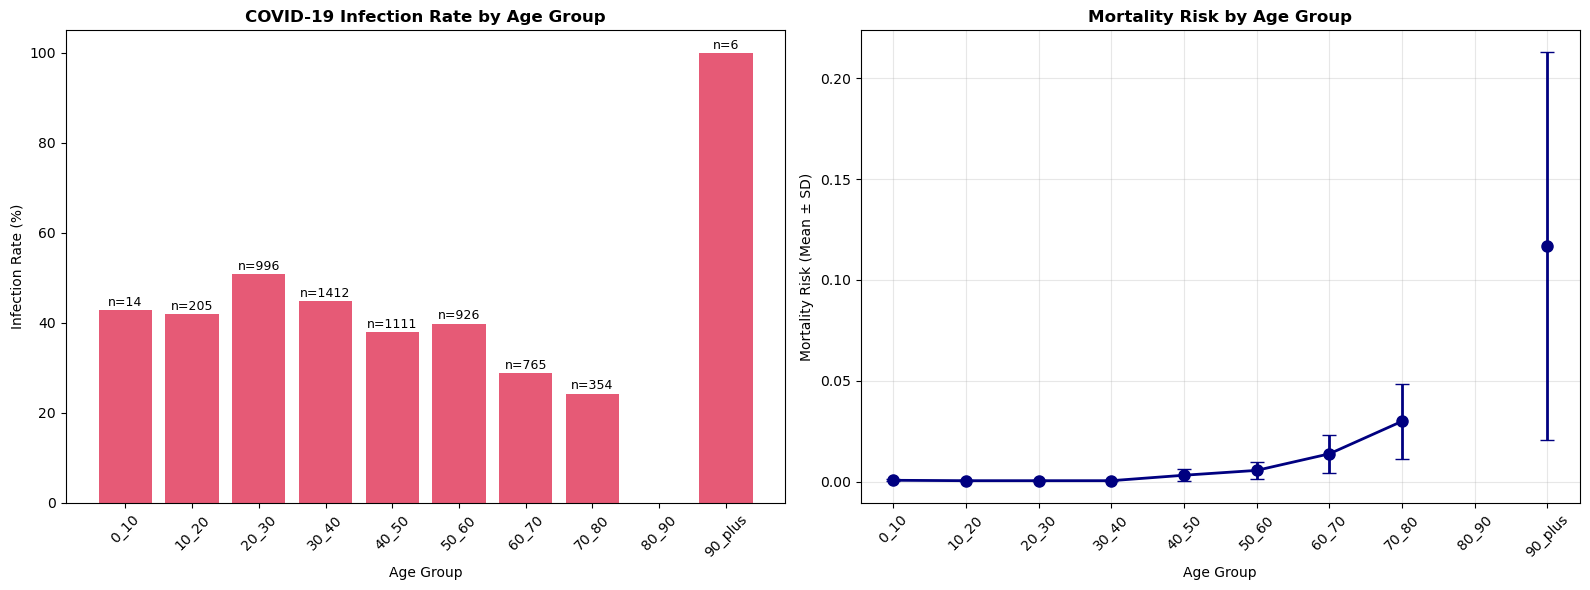

In [345]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# COVID-19 infection rates by age
bars1 = ax1.bar(age_analysis.index, age_analysis['infection_rate_pct'], 
               color='crimson', alpha=0.7)
ax1.set_title('COVID-19 Infection Rate by Age Group', fontweight='bold')
ax1.set_xlabel('Age Group')
ax1.set_ylabel('Infection Rate (%)')
ax1.tick_params(axis='x', rotation=45)

# Add sample size annotations
for i, (idx, row) in enumerate(age_analysis.iterrows()):
    total = int(row['total_cases'])
    rate = row['infection_rate_pct']
    ax1.annotate(f'n={total}', xy=(i, rate), xytext=(0, 3),
                textcoords='offset points', ha='center', fontsize=9)

# Mortality risk by age
ax2.errorbar(x=range(len(age_analysis)), y=age_analysis['mean_mortality_risk'],
            yerr=age_analysis['std_mortality_risk'], fmt='o-', capsize=5,
            color='navy', linewidth=2, markersize=8)
ax2.set_title('Mortality Risk by Age Group', fontweight='bold')
ax2.set_xlabel('Age Group')
ax2.set_ylabel('Mortality Risk (Mean ± SD)')
ax2.set_xticks(range(len(age_analysis)))
ax2.set_xticklabels(age_analysis.index, rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Correlation Analysis: COVID-19 Impact on Variable Relationships

This part eamines how variable correlations differ between COVID-positive and COVID-negative populations to understand the disease's impact on risk factor relationships.

In [346]:

# Use key variables that are already processed for correlation analysis
# Focus on the most important variables identified in previous sections
analysis_vars = ['age_numeric', 'height', 'weight', 'bmi', 'contacts_count', 
                'public_transport_count', 'worried', 'risk_mortality',
                'asthma', 'heart_disease', 'diabetes', 'compromised_immune',
                'health_worker', 'nursing_home']

# Filter to variables that actually exist in our dataframe
available_analysis_vars = [var for var in analysis_vars if var in df.columns]

# Split data by COVID status using the cleaned dataframe
covid_positive_subset = df[df['covid19_positive'] == True][available_analysis_vars]
covid_negative_subset = df[df['covid19_positive'] == False][available_analysis_vars]

print("--- Correlation Analysis: COVID Impact ---")
print(f"COVID-positive cases: {len(covid_positive_subset)}")
print(f"COVID-negative cases: {len(covid_negative_subset)}")
print(f"Available variables: {', '.join(available_analysis_vars)}")

--- Correlation Analysis: COVID Impact ---
COVID-positive cases: 2335
COVID-negative cases: 3454
Available variables: age_numeric, height, weight, bmi, contacts_count, public_transport_count, worried, risk_mortality, asthma, heart_disease, diabetes, compromised_immune, health_worker, nursing_home


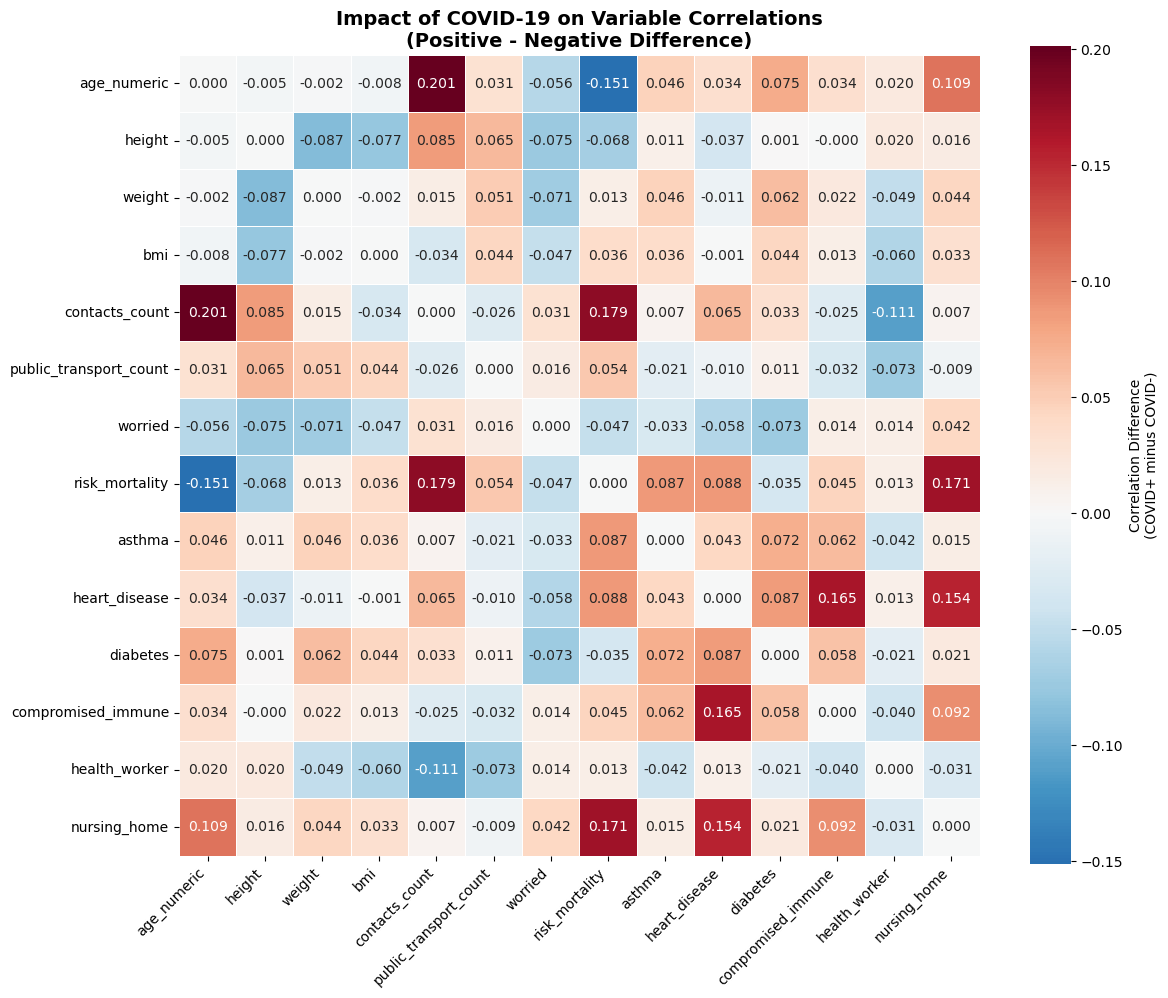

--- Largest Correlation Changes Due to COVID-19 ---
                     Variable_Pair  Correlation_Change
      age_numeric - contacts_count            0.201114
   contacts_count - risk_mortality            0.179459
     risk_mortality - nursing_home            0.170606
heart_disease - compromised_immune            0.165279
      heart_disease - nursing_home            0.154089
      age_numeric - risk_mortality           -0.151317
    contacts_count - health_worker           -0.111081
        age_numeric - nursing_home            0.108977


In [347]:
# Calculate correlation differences
corr_positive = covid_positive_subset.corr()
corr_negative = covid_negative_subset.corr()
corr_difference = corr_positive - corr_negative

# Create visualization
plt.figure(figsize=(12, 10))
sns.heatmap(corr_difference, annot=True, cmap='RdBu_r', center=0, 
           square=True, linewidths=0.5, fmt='.3f',
           cbar_kws={"label": "Correlation Difference\n(COVID+ minus COVID-)"})

plt.title('Impact of COVID-19 on Variable Correlations\n(Positive - Negative Difference)', 
         fontweight='bold', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Identify largest correlation changes
mask = np.triu(np.ones_like(corr_difference, dtype=bool), k=1)
upper_triangle = corr_difference.where(mask)

largest_changes = []
for col in upper_triangle.columns:
    for idx in upper_triangle.index:
        if not pd.isna(upper_triangle.loc[idx, col]) and abs(upper_triangle.loc[idx, col]) > 0.1:
            largest_changes.append({
                'Variable_Pair': f"{idx} - {col}",
                'Correlation_Change': upper_triangle.loc[idx, col]
            })

if largest_changes:
    changes_df = pd.DataFrame(largest_changes).sort_values('Correlation_Change', 
                                                          key=abs, ascending=False)
    print("--- Largest Correlation Changes Due to COVID-19 ---")
    print(changes_df.to_string(index=False))

In [348]:
#write new dataframe to CSV
df.to_csv("processed_medical_dataset.csv", index=False)
print("\n--- Data Processing Complete ---")


--- Data Processing Complete ---
